In [1]:
import os
import pandas as pd
import librosa
import numpy as np
from tqdm import tqdm
from joblib import Parallel, delayed
import matplotlib .pyplot as plt
from scipy.io import wavfile as wav
from IPython.display import Audio

In [2]:
File_Name = "/kaggle/input/speach-data/UrbanSound/data/air_conditioner/101729.wav"

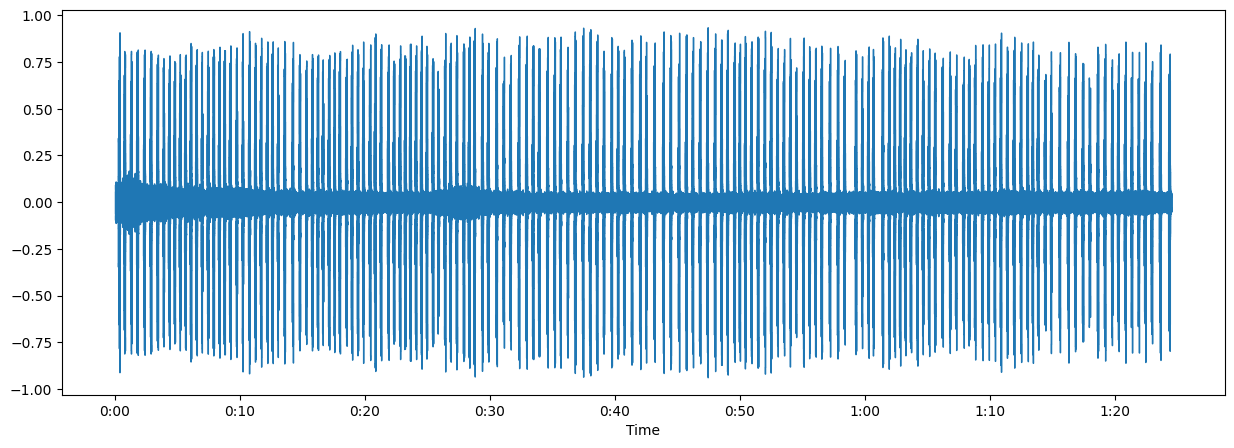

In [3]:
plt.figure(figsize=(15,5))
data, sample = librosa.load(File_Name)
librosa.display.waveshow(data, sr = sample)

In [4]:
pd.read_csv("/kaggle/input/speach-data/UrbanSound/data/air_conditioner/101729.csv")

,0.000000,84.580021,2,air_conditioner


In [5]:
audio_data, sample_rate = librosa.load(File_Name)

In [6]:
print(audio_data)

[ 0.00595073  0.02804295 -0.02763734 ... -0.00177902 -0.0060231
  0.        ]


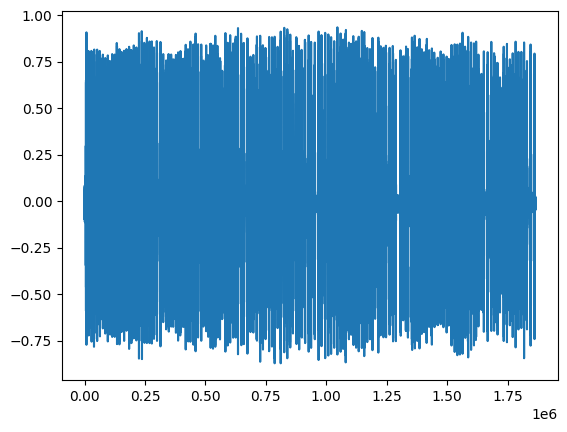

In [7]:
plt.plot(audio_data)

In [8]:
wav_sample_rate, wav_audio = wav.read(File_Name)

In [9]:
wav_audio

array([[ 31467264,  31467520],
       [ 38998272,  38998272],
       [ 44205568,  44205568],
       ...,
       [-14365696, -14365696],
       [-26234368, -26234368],
       [-17609984, -17609984]], dtype=int32)

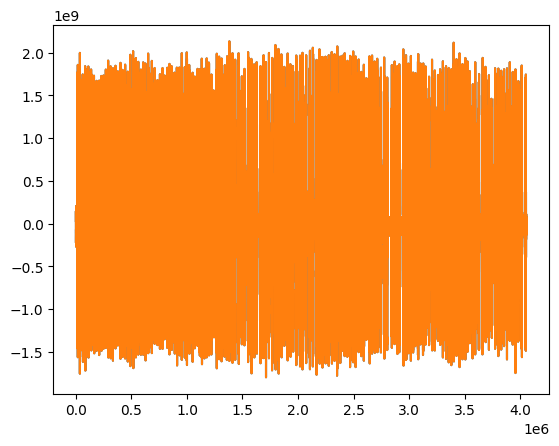

In [10]:
plt.plot(wav_audio)

In [11]:
DataPath = "/kaggle/input/speach-data/UrbanSound/data"

In [12]:
data = []
for f in os.listdir(DataPath):
    for aud in os.listdir(os.path.join(DataPath,f)):
        if aud.endswith((".wav",'.mp3')):
            end = aud.split('.')[1]
            path = os.path.join(DataPath,f,aud)
            df = pd.read_csv(path.replace(end,'csv'),header=None)
            df['FilePath'] = path
            data.append(df)

In [13]:
combined_df = pd.concat(data, ignore_index=True)

In [14]:
combined_df

,0,1,2,3,FilePath
0,32.852372,52.478465,1,jackhammer,/kaggle/input/speach-data/UrbanSound/data/jack...
1,57.903068,72.470261,1,jackhammer,/kaggle/input/speach-data/UrbanSound/data/jack...
2,0.429800,2.344362,1,jackhammer,/kaggle/input/speach-data/UrbanSound/data/jack...
3,3.125816,10.569165,1,jackhammer,/kaggle/input/speach-data/UrbanSound/data/jack...
4,11.956246,13.968490,1,jackhammer,/kaggle/input/speach-data/UrbanSound/data/jack...
...,...,...,...,...,...
2492,7.318298,7.885858,1,car_horn,/kaggle/input/speach-data/UrbanSound/data/car_...
2493,13.299687,13.403296,1,car_horn,/kaggle/input/speach-data/UrbanSound/data/car_...
2494,13.702351,13.860120,1,car_horn,/kaggle/input/speach-data/UrbanSound/data/car_...
2495,296.189280,298.389901,2,car_horn,/kaggle/input/speach-data/UrbanSound/data/car_...


In [15]:
combined_df.columns = ['Start', 'End', 'salience', 'file_class','FilePath']

In [16]:
combined_df.head()

,Start,End,salience,file_class,FilePath
0,32.852372,52.478465,1,jackhammer,/kaggle/input/speach-data/UrbanSound/data/jack...
1,57.903068,72.470261,1,jackhammer,/kaggle/input/speach-data/UrbanSound/data/jack...
2,0.429800,2.344362,1,jackhammer,/kaggle/input/speach-data/UrbanSound/data/jack...
3,3.125816,10.569165,1,jackhammer,/kaggle/input/speach-data/UrbanSound/data/jack...
4,11.956246,13.968490,1,jackhammer,/kaggle/input/speach-data/UrbanSound/data/jack...


In [17]:
combined_df.drop(['Start','End','salience'],inplace= True,axis=1)

In [18]:
combined_df.head()

,file_class,FilePath
0,jackhammer,/kaggle/input/speach-data/UrbanSound/data/jack...
1,jackhammer,/kaggle/input/speach-data/UrbanSound/data/jack...
2,jackhammer,/kaggle/input/speach-data/UrbanSound/data/jack...
3,jackhammer,/kaggle/input/speach-data/UrbanSound/data/jack...
4,jackhammer,/kaggle/input/speach-data/UrbanSound/data/jack...


In [19]:
combined_df['FilePath'][0]

'/kaggle/input/speach-data/UrbanSound/data/jackhammer/90013.wav'

In [41]:
pip install resampy

Note: you may need to restart the kernel to use updated packages.


In [21]:
# X_train = []
# y_train = []
# for i, file in tqdm(combined_df.iterrows()):
#     y_train.append(file['file_class'])
#     audio, sample_rate = librosa.load( file['FilePath'], res_type = 'kaiser_fast') 
#     mfccs_features = librosa.feature.mfcc(y = audio, sr = sample_rate, n_mfcc = 40)
#     mfccs_scaled_features = np.mean(mfccs_features.T, axis = 0)
#     X_train.append(mfccs_scaled_features)

In [22]:
# Function to process each file and extract features
def process_file(row):
    file_path = row['FilePath']
    try:
        audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
        mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
        return mfccs_scaled_features, row['file_class']
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

In [23]:
# Parallel processing using joblib
results = Parallel(n_jobs=-1)(delayed(process_file)(row) for _, row in tqdm(combined_df.iterrows(), total=combined_df.shape[0]))

  9%|▉         | 224/2497 [04:20<23:28,  1.61it/s]  /tmp/ipykernel_34/1677330432.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
/opt/conda/lib/python3.10/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 18%|█▊        | 460/2497 [06:05<04:42,  7.22it/s]  Note: Illegal Audio-MPEG-Header 0x41474472 at offset 3193125.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x41474472 at offset 3193125.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
 19%|█▊        | 464/2497 [06:06<04:37,  7.32it/s]Note: Illegal Audio-MPEG-Header 0x41474472 at offset 3193125.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x41474472 at offset 3193125.
Note: Tryi

In [24]:
# Filter out None results
results = [res for res in results if res is not None]

In [25]:
# Separate features and labels
X = [res[0] for res in results]
y = [res[1] for res in results]

In [26]:
# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

print(X.shape)
print(y.shape)

(2497, 40)
(2497,)


In [27]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
y = to_categorical(labelencoder.fit_transform(y))

2024-06-04 22:13:21.119811: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-04 22:13:21.119931: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-04 22:13:21.246389: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [28]:
from sklearn.model_selection import train_test_split

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=0)

In [30]:
X_train

array([[-1.9133745e+02,  6.5682541e+01, -1.9949068e+01, ...,
        -3.4528419e-01, -4.0944085e+00, -1.6918128e+00],
       [-3.3865366e+02, -3.3753181e+01, -1.8095858e+01, ...,
         1.3337693e+00, -7.9725564e-01,  7.2243166e+00],
       [-1.5547110e+02,  1.1296192e+02,  4.9549832e+00, ...,
        -5.5078921e+00, -3.2485542e+00, -4.8897524e+00],
       ...,
       [-4.1042496e+02,  5.6927937e+01,  1.7500263e+01, ...,
        -3.8735844e-02,  5.7461527e-03, -2.8678203e-01],
       [-2.6571164e+02,  1.3310483e+02, -2.8447809e+01, ...,
         2.1982422e+00, -1.3623499e+00,  8.3433247e-01],
       [-3.5075253e+02,  6.5578613e+01,  1.1886250e+01, ...,
         1.0012325e+00,  4.6324113e-01, -6.9148272e-02]], dtype=float32)

In [31]:
y_train

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [32]:
print("X_train shape: ",X_train.shape)
print("y_train shape: ",y_train.shape)
print("X_test shape: ",X_test.shape)
print("y_test shape: ",y_test.shape)

X_train shape:  (1997, 40)
y_train shape:  (1997, 10)
X_test shape:  (500, 40)
y_test shape:  (500, 10)


In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [34]:
# No of classes
num_labels = y_train.shape[1]

In [35]:
# Call the model.
model = Sequential()

# First hidden layer.
model.add(Dense(100, input_shape = (40,)))
model.add(Activation('relu'))

# Second hidden layer.
model.add(Dense(200))
model.add(Activation('relu'))

# Third hidden layer.
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Final layer.  ==> Output layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [36]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 100)            │         4,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,410 (177.38 KB)

 Trainable params: 45,410 (177.38 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
model.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = 'adam')

In [38]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 100
num_batch_size = 64

checkpointer = ModelCheckpoint(filepath = 'saved_models/audio_classification.keras', 
                               verbose = 1, save_best_only = True)
start = datetime.now()

model.fit(X_train, y_train, batch_size = num_batch_size, epochs = num_epochs,
          validation_data = (X_test, y_test), callbacks = [checkpointer], verbose = 1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1928 - loss: 11.2109 

I0000 00:00:1717539215.739629     177 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.1949 - loss: 10.7059
Epoch 1: val_loss improved from inf to 1.91171, saving model to saved_models/audio_classification.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.1955 - loss: 10.5563 - val_accuracy: 0.3480 - val_loss: 1.9117
Epoch 2/100
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3065 - loss: 1.9786 
Epoch 2: val_loss improved from 1.91171 to 1.73072, saving model to saved_models/audio_classification.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3089 - loss: 1.9760 - val_accuracy: 0.4580 - val_loss: 1.7307
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3839 - loss: 1.8359 
Epoch 3: val_loss improved from 1.73072 to 1.63373, saving model to saved_models/audio_classification.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3839 - loss: 1.8356 - val_accuracy: 0.4200 - val_loss: 1.6337
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3849 - loss: 1.7472 


In [39]:
model.predict(X_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


array([[2.9789089e-04, 8.5734349e-01, 2.6361682e-02, ..., 1.7954169e-02,
        2.3657499e-02, 2.6884382e-03],
       [6.1281638e-09, 4.7373353e-04, 1.0530856e-04, ..., 2.3905758e-10,
        9.9780625e-01, 3.6149601e-08],
       [2.5289705e-02, 1.7418404e-01, 3.5143171e-02, ..., 4.0871274e-02,
        2.3597609e-02, 7.3791586e-02],
       ...,
       [1.0919540e-10, 2.6901216e-05, 3.0499152e-05, ..., 1.1776244e-11,
        9.3365157e-01, 2.4402342e-09],
       [1.9138531e-11, 1.4789019e-12, 4.2826005e-13, ..., 4.3471108e-18,
        6.1274301e-21, 6.9005037e-16],
       [1.4980434e-02, 3.1990703e-02, 2.4177264e-01, ..., 3.7517326e-03,
        8.1597149e-02, 4.9803488e-02]], dtype=float32)

In [46]:
filename="/kaggle/input/speach-data/UrbanSound/data/air_conditioner/100852.mp3"
audio, sample_rate = librosa.load(filename) 
mfccs_features = librosa.feature.mfcc(y=audio, sr = sample_rate, n_mfcc = 40)
mfccs_scaled_features = np.mean(mfccs_features.T, axis = 0)

print(mfccs_scaled_features)
mfccs_scaled_features=mfccs_scaled_features.reshape(1, -1)
print(mfccs_scaled_features)
print(mfccs_scaled_features.shape)

# predicted_label = np.argmax(model.predict(mfccs_scaled_features), axis=-1)
predicted_label = np.argmax(model.predict(mfccs_scaled_features), axis=-1)
print(predicted_label)

# Show the input include in any of output class.
prediction_class = labelencoder.inverse_transform(predicted_label) 
prediction_class

[-44.569748    69.34106    -36.852974    37.56195      8.150056
  12.03823      7.778629     5.156759    -2.9015367    1.7349181
  -2.705109     3.7856865   -2.0368907    8.477686    -4.3359904
   7.387903    -2.5860765    5.2027316   -3.2437415    7.8732424
  -2.175326     0.9915558   -1.1113979    3.505082    -2.918919
   0.8290312   -3.8783574   -0.14262609  -3.2767274   -2.4249303
  -6.117771    -2.3658676   -3.5777326   -0.54515046  -2.083634
   1.056437    -0.7416937    1.9439859   -3.028968     1.6063069 ]
[[-44.569748    69.34106    -36.852974    37.56195      8.150056
   12.03823      7.778629     5.156759    -2.9015367    1.7349181
   -2.705109     3.7856865   -2.0368907    8.477686    -4.3359904
    7.387903    -2.5860765    5.2027316   -3.2437415    7.8732424
   -2.175326     0.9915558   -1.1113979    3.505082    -2.918919
    0.8290312   -3.8783574   -0.14262609  -3.2767274   -2.4249303
   -6.117771    -2.3658676   -3.5777326   -0.54515046  -2.083634
    1.056437    -0.741

array(['air_conditioner'], dtype='<U16')